In [2]:
# import the nltk package and download the stop words
import nltk
nltk.download('stopwords')

# import other useful language processing tools
import spacy
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim.parsing.preprocessing import strip_short
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

# import packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from sklearn.manifold import TSNE
import pyLDAvis.gensim

# import other useful packages 
import re
import pandas as pd
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gznyy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# load in data
poetry_dataset = pd.read_csv('poetry.csv')
poetry_dataset.head()

,author,content,poem name,age,type
0,WILLIAM SHAKESPEARE,Let the bird of loudest lay\r\nOn the sole Ara...,The Phoenix and the Turtle,Renaissance,Mythology & Folklore
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,"Sir Charles into my chamber coming in,\r\nWhen...",An Epilogue to the Above,Renaissance,Mythology & Folklore
2,THOMAS BASTARD,"Our vice runs beyond all that old men saw,\r\n...","Book 7, Epigram 42",Renaissance,Mythology & Folklore
3,EDMUND SPENSER,"Lo I the man, whose Muse whilome did maske,\r\...","from The Faerie Queene: Book I, Canto I",Renaissance,Mythology & Folklore
4,RICHARD BARNFIELD,"Long have I longd to see my love againe,\r\nSt...",Sonnet 16,Renaissance,Mythology & Folklore


In [4]:
def stop_word_extend(extension_list, extension_file):
    '''Function to extend the default nltk stopwords list
    
    Arguments
    ---------
    extension_list: a list of words to extend the list of stop words
    extension_file: a .txt file that contains a list of words to extend the list of stop words
    
    Returns:
    --------
    en_stop_words: the final list of stop words
    '''
    en_stop_words = stopwords.words('english')
    en_stop_words.extend(extension_list)
    more_stopwords = open(extension_file).read().split()
    en_stop_words.extend(more_stopwords)
    en_stop_words = set(en_stop_words)
    return en_stop_words

# the following domain specific stopwords are added to the stopwords list 
extension_list = ['thy', 'thou', 'let', 'thee', 'thine', 'thyself', 'tis', 'doth',
                  'upon', 'till', 'unto', 'hath', 'ye', '-PRON-', 'shalt']

# set up and print out the resulting stopwords list
stopword_list = set(stop_word_extend(extension_list, 'stopwords_extend.txt'))

print("the total number of stopwords: {}".format(len(stopword_list)))
list(stopword_list)[:10]

the total number of stopwords: 606


['-',
 'needing',
 'after',
 'don',
 "that's",
 '!?',
 'somebody',
 'through',
 'made',
 'theyve']

In [5]:
def text_prepare(text, stop_word_extension_list, extension_list):
    '''Function to preprocess each poetry of all the poetires listed in the content column of the dataset
    
    Arguments
    ---------
    text: a string represents individual poetry
    stop_word_extension_list: a list of words to extend the list of stop words
    extension_list: a .txt file that contains a list of words to extend the list of stop words
    
    Returns
    -------
    text: preprocessed text of individual poetry
    '''
    text = text.lower().strip() # strip spaces before and after each line of texts
    # extract the lemma of words so that words can be reduced to their basic forms
    text = " ".join([token.lemma_ for token in nlp(text)]) 
    text = " ".join([word for word in simple_preprocess(text, deacc=True)]) # remove punctuations
    text = " ".join([word for word in text.split() if word not in stop_word_extend(stop_word_extension_list, 
      extension_list)]) # remove stopwords
    text = re.sub(r'\s*lov\s', 'love', text) 
    text = strip_short(text) # remove words that are too short
    return text

# function to preprocess all the poetries and get rid of problematic rows that 
# contain copyright information 
def get_text_prepared(poetry_dataset, stop_word_extension_file, extension_list):
    '''Function to preprocess all the poetries and get rid of problematic rows that contain copyright information
    
    Arguments
    ---------
    poetry_dataset: the .csv file that is the poetry dataset
    stop_word_extension_file: a .txt file that contains a list of words to extend the list of stop words
    extension_list: a list of words to extend the list of stop words
    
    Returns
    -------
    text_data: a list containing list of words from each poetry after the preprocessing
    poetry_dataset_reduced: a reduced version of the poetry dataset after the rows containing the copyright information have been deleted
    '''
    text_data = []
    good_index = []
    for i, poetry in enumerate(poetry_dataset['content']):
        if any(x in ['copyright', 'permission', 'published'] for x in poetry.lower().split()):
            continue
        text_data.append(text_prepare(poetry, extension_list, 
          stop_word_extension_file).split())
        good_index.append(i)
    poetry_dataset_reduced = poetry_dataset.iloc[good_index, :]
    return text_data, poetry_dataset_reduced

In [6]:
# preprocess all poetries
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
text_data, poetry_dataset_reduced = get_text_prepared(poetry_dataset,
                                                      'stopwords_extend.txt',
                                                      extension_list)

# print out a comparison between the preprocessed and raw text 
pprint.pprint(' '.join(text_data[0]))
print(poetry_dataset['content'][0])

('bird loud lie sole arabian tree herald sad trumpet sound chaste wing obey '
 'shriek harbinger foul precurrer fiend augur fever troop near session '
 'interdict fowl tyrant wing save eagle feather king obsequy strict priest '
 'surplice white defunctive music death divine swan lest requiem lack pron '
 'treble date crow sable gender mak breath giv tak mongst pron mourner anthem '
 'commence love constancy dead phoenix turtle flee mutual flame hence '
 'pronlovelove twain essence distinct division none love slay heart remote '
 'asunder distance space twixt turtle pron queen pron pron wonder pron love '
 'shine turtle pron flame phoenix sight mine property appal self single nature '
 'double name neither call reason pron confound division grow pron neither '
 'simple compound pron cry true twain seemeth concordant love reason reason '
 'none remain whereupon pron threne phoenix dove supreme star love chorus pron '
 'tragic scene threno beauty truth rarity grace simplicity enclos cinde

In [7]:
def make_ngrams(text_data, min_count, threshold):
    '''Function to combine words together to form phrases so that the modeling afterwards can learn some context.
    
    Arguments
    ---------
    text_data: list of documents each of which is a list of words
    min_count:
    threshold:
    
    Returns
    -------
    text_data: list of documents each of which is a list of words and trigrams
    '''
    bigram = Phrases(text_data, min_count=min_count, threshold=threshold)
    trigram = Phrases(bigram[text_data], threshold=threshold)

    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)

    def make_bi_tri_grams(text_data):
        text_data = [bigram_mod[doc] for doc in text_data]
        text_data = [trigram_mod[doc] for doc in text_data]
        return text_data

    text_data = make_bi_tri_grams(text_data=text_data)
    return text_data

In [8]:
def get_gensim_corpus(text_data):
    '''Function to get the dictionary and corpus for modeling. 
    
    Arguments
    ---------
    text_data: list of documents each of which is a list of words
    
    Returns
    -------
    corpus: list of documents each of which consists of tuple of word in their integer representation and their counts in the document
    dictionary: the mapping between words and their integer ids
    '''
    dictionary = corpora.Dictionary(text_data)
    dictionary.filter_extremes(no_below=5, no_above=0.2)
    corpus = [dictionary.doc2bow(text) for text in text_data]
    return corpus, dictionary

In [9]:
text_data_grams = make_ngrams(text_data, 5, 70)
corpus, dictionary = get_gensim_corpus(text_data_grams)

In [10]:
n_topics_search_range = np.arange(2, 8, 1) # the number of topics to try
coherence_scores = [] # list to store the coherence scores
models = [] # list to store the LDA models 

# loop to fit LDA models of different number of topics
for num_loops, n_topics in enumerate(n_topics_search_range):
    print("training LDA model with %d topics" % (n_topics))
    # fit the model
    topic_model_LDA = LdaModel(corpus=corpus, id2word=dictionary,
                               num_topics=n_topics, random_state=10,
                               update_every=1, chunksize=80,
                               passes=20, alpha='auto',
                               per_word_topics=True)
    
    # compute the coherence scores 
    coherence_score_LDA = CoherenceModel(model=topic_model_LDA, 
                                         texts=text_data, coherence='c_v', 
                                         dictionary=dictionary).get_coherence()
    
    # store the coherence scores and models 
    coherence_scores.append(coherence_score_LDA)
    models.append(topic_model_LDA)

# convert the coherence scores into a dataframe for plotting 
coherence_scores_data = pd.DataFrame(coherence_scores, index=n_topics_search_range)


training LDA model with 2 topics
training LDA model with 3 topics
training LDA model with 4 topics
training LDA model with 5 topics
training LDA model with 6 topics
training LDA model with 7 topics


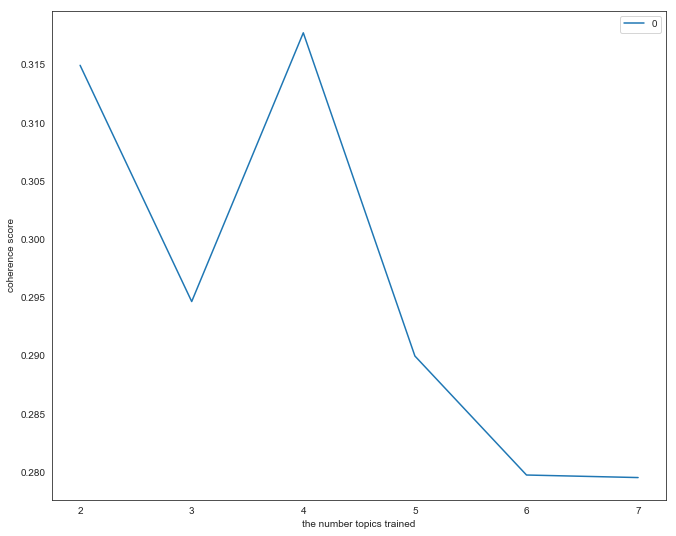

In [11]:
# graph the coherence score against the number of topics to choose the best number of topics to use 
# In this case, setting the number of topics to 4 seems a good choice
plt.figure(figsize=(11, 9))
sns.set_style('white')
sns.lineplot(data=coherence_scores_data)
plt.xlabel("the number topics trained")
plt.ylabel("coherence score")
plt.show()

In [13]:
# we can see what out topics are in terms of the words that make up our topics
model_used = models[2]
pprint.pprint(model_used.print_topics())

[(0,
  '0.024*"fair" + 0.016*"world" + 0.013*"fire" + 0.012*"true" + 0.009*"flower" '
  '+ 0.008*"earth" + 0.008*"burn" + 0.007*"dream" + 0.007*"heaven" + '
  '0.007*"star"'),
 (1,
  '0.009*"look" + 0.009*"hand" + 0.008*"sea" + 0.008*"water" + 0.007*"white" + '
  '0.007*"shadow" + 0.007*"wind" + 0.007*"sing" + 0.006*"cry" + '
  '0.006*"little"'),
 (2,
  '0.014*"live" + 0.011*"soul" + 0.009*"age" + 0.008*"youth" + 0.008*"lose" + '
  '0.008*"tell" + 0.008*"seek" + 0.008*"friend" + 0.007*"death" + '
  '0.007*"life"'),
 (3,
  '0.013*"soul" + 0.008*"bring" + 0.008*"sight" + 0.007*"mine" + 0.006*"body" '
  '+ 0.006*"grace" + 0.006*"delight" + 0.006*"rest" + 0.006*"tell" + '
  '0.006*"happy"')]


In [14]:
# we can use the pyLDAvis package to get a more detailed visualization of our topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_used, corpus, dictionary)
vis

C:\Users\gznyy\Anaconda3\envs\topic_model_env\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.252794  0.027769       1        1  36.767445
3     -0.096151  0.010803       2        1  29.747795
2     -0.052807 -0.195699       3        1  17.920774
0     -0.103836  0.157127       4        1  15.563989, topic_info=     Category        Freq      Term       Total  loglift  logprob
20    Default  145.000000      fair  145.000000  30.0000  30.0000
1098  Default  156.000000      soul  156.000000  29.0000  29.0000
243   Default   75.000000      fire   75.000000  28.0000  28.0000
336   Default   99.000000      live   99.000000  27.0000  27.0000
71    Default   87.000000      true   87.000000  26.0000  26.0000
524   Default  139.000000     world  139.000000  25.0000  25.0000
171   Default   63.000000     bring   63.000000  24.0000  24.0000
736   Default   77.000000       sea   77.000000  23.0000  23.0000
903   Default   48.000000       age   48.000000  22.0000  22.0000
674   Default   75.000000    flower   75.000000  21.0000  21.0000
498   Default   74.000000     water   74.000000  20.0000  20.0000
68    Default   65.000000      star   65.000000  19.0000  19.0000
265   Default   49.000000    friend   49.000000  18.0000  18.0000
535   Default   43.000000     youth   43.000000  17.0000  17.0000
648   Default   52.000000      burn   52.000000  16.0000  16.0000
343   Default   48.000000      lose   48.000000  15.0000  15.0000
757   Default   76.000000       sun   76.000000  14.0000  14.0000
214   Default   90.000000     earth   90.000000  13.0000  13.0000
259   Default   64.000000     forth   64.000000  12.0000  12.0000
339   Default  121.000000      look  121.000000  11.0000  11.0000
1026  Default   33.000000     child   33.000000  10.0000  10.0000
959   Default   43.000000    spirit   43.000000   9.0000   9.0000
311   Default   42.000000       ill   42.000000   8.0000   8.0000
62    Default   77.000000     sight   77.000000   7.0000   7.0000
397   Default   27.000000      read   27.000000   6.0000   6.0000
863   Default   73.000000    shadow   73.000000   5.0000   5.0000
107   Default   70.000000     dream   70.000000   4.0000   4.0000
284   Default   43.000000     happy   43.000000   3.0000   3.0000
663   Default   38.000000       doe   38.000000   2.0000   2.0000
1270  Default   23.000000      form   23.000000   1.0000   1.0000
...       ...         ...       ...         ...      ...      ...
831    Topic4   17.064966      hero   21.041319   1.6508  -5.4501
789    Topic4   18.283783      brow   23.202091   1.6220  -5.3811
242    Topic4   20.770620      fill   27.113560   1.5937  -5.2536
834    Topic4   12.342610  immortal   14.674613   1.6871  -5.7741
487    Topic4   20.527170     venus   28.337282   1.5378  -5.2654
71     Topic4   47.527061      true   87.067810   1.2548  -4.4259
524    Topic4   63.495411     world  139.705551   1.0716  -4.1362
959    Topic4   26.457052    spirit   43.397018   1.3653  -5.0116
648    Topic4   29.827663      burn   52.488213   1.2951  -4.8917
31     Topic4   19.650497      king   31.049107   1.4027  -5.3091
674    Topic4   34.978729    flower   75.642929   1.0889  -4.7324
40     Topic4   24.377792    nature   43.716824   1.2762  -5.0935
273    Topic4   20.165617     glory   32.922836   1.3700  -5.2832
906    Topic4   14.762256    appear   20.502712   1.5317  -5.5951
214    Topic4   33.453815     earth   90.313454   0.8671  -4.7770
68     Topic4   27.780920      star   65.634567   1.0005  -4.9628
107    Topic4   28.454075     dream   70.090515   0.9587  -4.9389
264    Topic4   15.992514     fresh   24.205969   1.4457  -5.5150
44     Topic4   24.667950      none   59.210556   0.9846  -5.0817
23     Topic4   21.254450     flame   44.212845   1.1278  -5.2306
878    Topic4   15.274259     steal   22.811111   1.4591  -5.5610
294    Topic4   27.856577    heaven   83.237480   0.7656  -4.9601
59     Topic4   19.889235      self   40.174889   1.1571  -5.2970
259

The above visualization contains the following elements:
* The bubbles on the left shows the marginal distribution of each topic. This is related to the percentage of tokens it contains. 
* The further away a bubble is from from another bubble the more different between their meanings. We can see from the above visualization that there is no overlapping among bubbles and they are all fairly big, meaning that these four topics are fairly distinct from each other and they are fairly important topics. This shows our topic modeling has worked properly. 
* From the bar graph on the right we can see the information about each word. The red bar indicates the frequency of the token within the topic and the light blue overall frequency within the corpus. 
* Furthermore, we can adjust the relevancy metric on the top to achieve a good balance between showing the word's importance in the whole corpus and within a specific topic. 

However, the labels assigned to topics returned by the pyLDAvis package do not correspond to the labels returned by the LDA model. So in order to use pyLDAvis, we need to take a look at the words that make up of our topics and make the following observations:
* topic one in the pyLDAvis corresponds to topic one returned by our LDA model
* topic two in the pyLDAvis corresponds to topic three returned by our LDA model
* topic three in the pyLDAvis corresponds to topic two returned by our LDA model
* topic four in the pyLDAvis corresponds to topic zero returned by our LDA model

In order to better understand our topics, we can connect the above visualization to the period and author information provided by our original dataset

C:\Users\gznyy\Anaconda3\envs\topic_model_env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


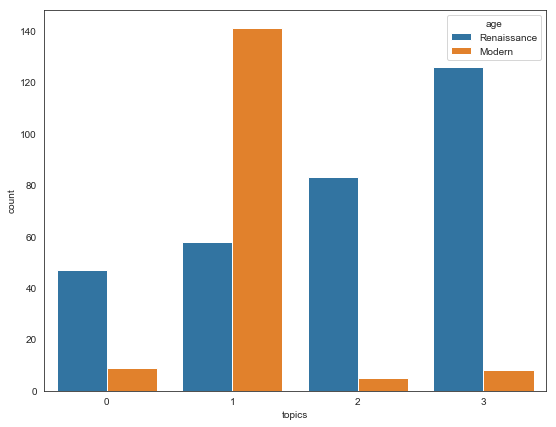

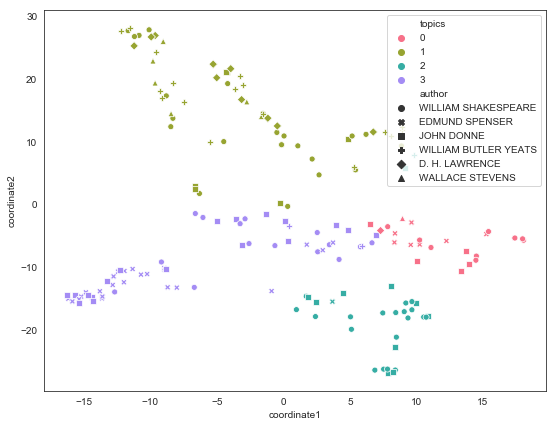

In [15]:
doc_topic = []
doc_dist_list = []
for document in corpus:
    # get topic distribution of each poem from the corpus
    doc_dist = model_used.get_document_topics(document, minimum_probability=0)
    doc_dist_list.append(list(map(lambda x: x[1], doc_dist)))
    
    # get the topic of each poem from the corpus by choosing the topic with the largest probability
    doc_dist_sorted = sorted(doc_dist, key=lambda x: x[1], reverse=True)
    doc_topic.append(doc_dist_sorted[0][0])

# store the topics as a new column in the original dataset
poetry_dataset_reduced['topics'] = doc_topic

# use Tsne to visualize the poems in a two dimensional plane based on their topic distributions
tsne_result = TSNE(random_state=10).fit_transform(doc_dist_list)
tsne_result = pd.DataFrame(tsne_result, columns=['coordinate1', 'coordinate2'])

poetry_dataset_reduced.reset_index(inplace=True, drop=True)
poetry_dataset_prepared = pd.concat([poetry_dataset_reduced, tsne_result],
                                    axis=1)
poetry_dataset_prepared.astype({'topics': 'category'})

# choose the authors that we are going to investigate
author_list = ['WILLIAM SHAKESPEARE', 'EDMUND SPENSER', 'WILLIAM BUTLER YEATS',
              'D. H. LAWRENCE', 'JOHN DONNE', 'WALLACE STEVENS']
author_mask = poetry_dataset_prepared.author.isin(author_list)
poetry_dataset_prepared_reduced = poetry_dataset_prepared.loc[author_mask,:]

# plot the count of each topic color seperated by period
plt.figure(figsize=(9,7))
sns.countplot(x='topics', hue='age', data=poetry_dataset_prepared)

# visualize the poems in a two dimensional plane with different colors/topics and d
plt.figure(figsize=(9,7))
num_topics = len(set(poetry_dataset_reduced['topics']))
sns.scatterplot(x='coordinate1', y='coordinate2', style='author',
                hue='topics', data=poetry_dataset_prepared_reduced,
               palette=sns.color_palette("husl", num_topics))

plt.show()

By taking a look at the above graphs, we can make the following observations:
* The first graph shows that topic one returned by our LDA model can be classified as modern. Remember that topic one from our LDA model corresponds to topic one from pyDLAvis visualization, which shows many words related to natural scenery such as "sea", "water", "wind", "tree", etc.
* by contrast the first graph shows other topics can be classified as Renaissance. Topics three, for example, which corresponds to topic two from pyLDAvis visualization, shows many words related to religious topics such as "soul" and "grace" as well as human condition such as "happy" and "woe". 
* The second graph presents information relating the connection between our topics and the authors (sampled from the original dataset who represent their respective period)
* We can see that Shakespeare's poems are included in all four topics. This shows his poems not only include Renaissance elements but also anticipate modern themes as well. 
* Two authors, namely John Donne and Edmund Spenser, make up of topic three which corresponds to topic two in the pyLDAvis visualization. The religious tone of topic three, therefore, can explained by John Donne being a famous religious poet.
* It is also interesting to note that topic one (mentioned above as the topic dominated by words related to natural scenery) is dominated by two authors, William Butler Yeats and William Shakespeare, both of whom are influenced by English and Irish mythology. 

Reference
* https://www.aclweb.org/anthology/W14-3110 for the explanation of the pyLDAvis visualization technique
* https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05 for some basic explanation of how LDA works
* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/ for understanding text preprocessing and model selection using coherence score 